Found 6579 images belonging to 38 classes.
Found 2172 images belonging to 38 classes.
Found 10547 images belonging to 38 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 151s 581ms/step - accuracy: 0.0206 - loss: 3.6245 - val_accuracy: 0.0166 - val_loss: 3.6373
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 94s 443ms/step - accuracy: 0.0133 - loss: 3.6700 - val_accuracy: 0.0276 - val_loss: 3.6365
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 93s 439ms/step - accuracy: 0.0348 - loss: 3.6611 - val_accuracy: 0.0207 - val_loss: 3.6380
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 93s 442ms/step - accuracy: 0.0174 - loss: 3.7438 - val_accuracy: 0.0331 - val_loss: 3.6371
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 93s 440ms/step - accuracy: 0.0199 - loss: 3.6927 - val_accuracy: 0.0313 - val_loss: 3.6378
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 93s 440ms/step - accuracy: 0.0343 - loss: 3.6101 - val_accuracy: 0.0124 - val_loss: 3.6374
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 93s 439ms/step - accuracy: 0.0170 - loss: 3.6369 - val_accuracy: 0.0212 - val_loss: 3.6368
Epoch 8/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 93s 438ms/step - accuracy: 0.0279 - loss: 3.6120 - va

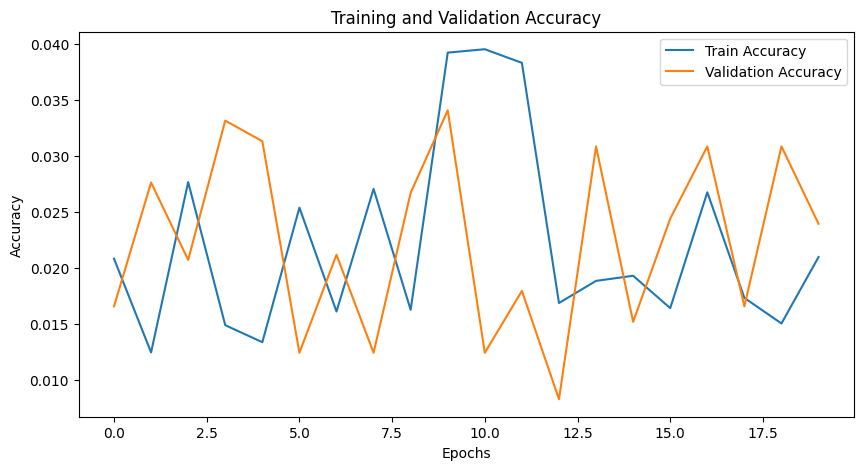

330/330 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step


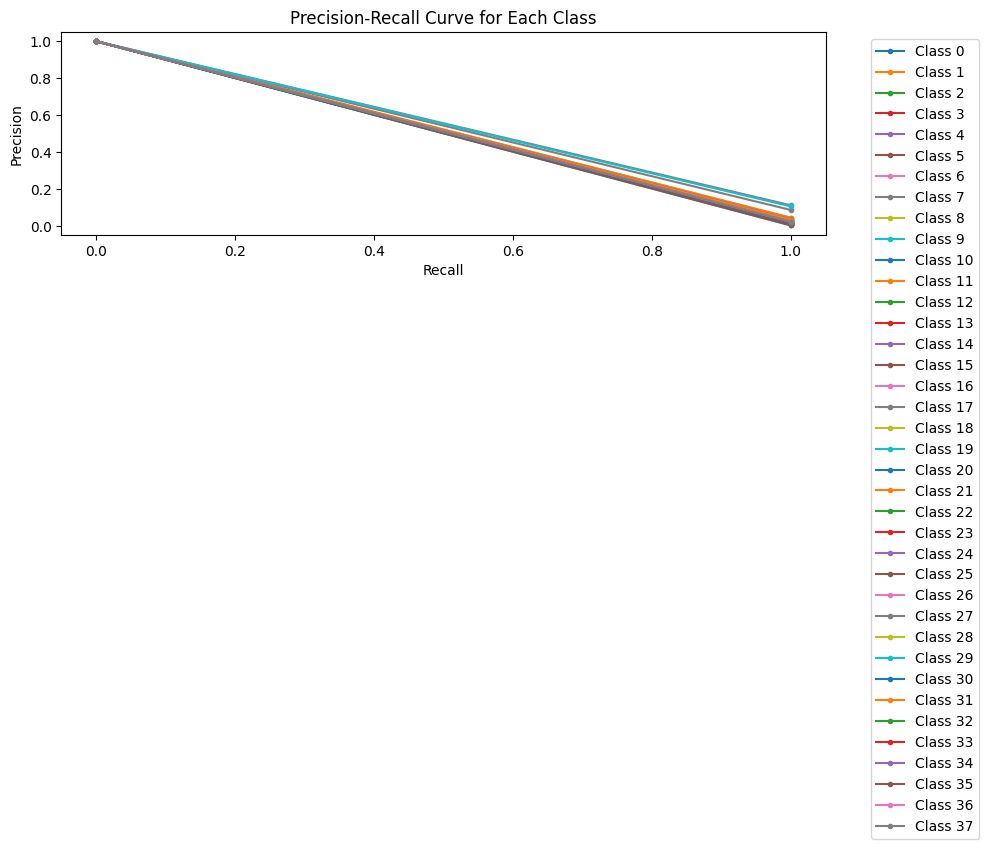

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve

def inception_module(x, filters):
    f1, f3_r, f3, f5_r, f5, pool_proj = filters

    conv1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    conv3 = Conv2D(f3_r, (1, 1), padding='same', activation='relu')(x)
    conv3 = Conv2D(f3, (3, 3), padding='same', activation='relu')(conv3)

    conv5 = Conv2D(f5_r, (1, 1), padding='same', activation='relu')(x)
    conv5 = Conv2D(f5, (5, 5), padding='same', activation='relu')(conv5)

    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(pool)

    output = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return output

def googlenet_model(input_size=(224, 224, 3), num_classes=38):
    inputs = Input(input_size)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = inception_module(x, [384, 192, 384, 48, 128, 128])

    x = AveragePooling2D((7, 7), strides=(1, 1))(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model

def main():
    # Update paths for Kaggle environment
    train_folder = '/kaggle/input/plant-village/train/train'
    test_folder = '/kaggle/input/plant-village/test/test'

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.25
    )

    # Only rescaling for testing
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Load data using flow_from_directory
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse',
        subset='validation'
    )

    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse',
        shuffle=False
    )

    # Get number of classes
    num_classes = len(train_generator.class_indices)

    # Create and compile model
    model = googlenet_model(input_size=(224, 224, 3), num_classes=num_classes)
    model.compile(
        optimizer=Adam(learning_rate=0.0007),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Calculate class weights
    class_weights = compute_class_weight(
        "balanced",
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weight_dict = dict(enumerate(class_weights))

    # Train model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=20,
        class_weight=class_weight_dict
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    # Generate predictions for PR curve
    test_predictions = model.predict(test_generator)
    y_true = tf.keras.utils.to_categorical(test_generator.classes, num_classes)

    # Plot PR curves
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], test_predictions[:, i])
        plt.plot(recall, precision, marker='.', label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()